# (2) CV WINTER 2023 - Blurred Image Detection via Supervised Learning Using Different Approaches

### Project Description
There is a dataset of images, par of which is blurred. The task is to develop a machine learning algorithm to detect whether the image is blurred or sharp on the unknown dataset.

### Data Description
The dataset consists of images, and some of them are blurred. The images are blurred using augmentation.

Data files:
- ```train``` - a folder for training
- ```test``` - a folder with images, for which we make predicitons
- ```train.csv``` - labels (answers) to the train sample: **if 1, the image is blurred.**

### Project Methodology

There are two approaches, which can be applied to solving a classification problem for blurred image detection:
- 1) To use  Laplacian or Fourier algorithms to construct the algorithm for interating through the dataset and detecting the blurred images by an advised threshold from the research literature (Liu, 2008; Hsu, 2008, Su et al., 2011). To test manually the predictions.
- 2) To construct a convolutional neural network, train and test it on unseen given test sample. The quality metric is 'accuracy'; the overfitting problem is to be considered; data augmentation is used to prevent overfitting.

#### Final project output: ***a .csv file with predictions for a test (unseen) data.***

### Data
Dataset can be found [here](https://drive.google.com/drive/folders/1CWsLeFXwthxo7n5j6CYZlW_cS9X0oFVP?usp=share_link).


### Project Team: _Ruba, Yulia, Dharmaraj, Jay_

### Papers:
- [Hsu, P., & Chen, B. Y. (2008, January). Blurred image detection and classification. In International conference on multimedia modeling (pp. 277-286). Springer, Berlin, Heidelberg.](https://jiaya.me/all_final_papers/blur_detect_cvpr08.pdf)
- [Su, B., Lu, S., & Tan, C. L. (2011, November). Blurred image region detection and classification. In Proceedings of the 19th ACM international conference on Multimedia (pp. 1397-1400).](https://fled.github.io/paper/blur.pdf)
- [Liu, R., Li, Z., & Jia, J. (2008, June). Image partial blur detection and classification. In 2008 IEEE conference on computer vision and pattern recognition (pp. 1-8). IEEE.](http://graphics.im.ntu.edu.tw/docs/mmm08.pdf)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2
plt.style.use('dark_background')
import seaborn as sns
import ssl
import torch
import glob

from ipyplot import plot_images
from pylab import *
from PIL import Image
from sklearn.utils import shuffle
from keras.models import Sequential
from tqdm.keras import TqdmCallback
from keras.preprocessing import image
from sklearn import svm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import warnings
warnings.simplefilter("ignore")

# show the version of tf
print(cv2.__version__)

2023-02-21 13:11:41.289395: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


4.7.0


## 1 Data Load

### 1.1 Loading images and labels from given datasets

In [2]:
labels = pd.read_csv('/Users/yuliabezginova/PycharmProjects/00_files-for_NLP/shift-cv-winter-2023/train.csv')
labels.head()

filename  blur
0  kagouracdzwrjjxzzedi.jpg   0.0
1  ahnamimqdfqoqdnozabc.jpg   0.0
2  gwhdadvghuzinmzhzssx.jpg   0.0
3  onqwabwwckubrydgbzly.jpg   0.0
4  ewpqdruddbokqyzzupcw.jpg   1.0

### Which batch_size value to put?
The best batch size to select depends on the application and the available resources (such as memory and computational power).

A larger batch size can result in faster training times, as more samples can be processed at once. However, it also increases the memory requirements of the model, and can result in a less accurate solution. A smaller batch size can result in more accurate solutions, but requires more training iterations and therefore takes longer to train.

In general, a batch size of 32 or 64 is a good starting point for most applications. For large datasets, batch sizes of 128 or 256 are common. However, it's important to keep in mind that the optimal batch size can vary depending on the complexity of the model and the specific characteristics of the dataset.

A common practice is to try different batch sizes and evaluate the performance of the model using a validation set. A batch size that results in the best performance on the validation set is likely to be a good choice for the final model.

It's also worth noting that when using large batch size, it's essential to use a technique called "Batch Normalization" as it helps to normalize the inputs to the model, which can improve the stability of the training process.

**In summary, the best batch size is not a fixed value and it's a hyperparameter that can be fine-tuned during model development. It's depend on resources, dataset and the complexity of the model.**


In [3]:
train_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2
)

validation_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255)

# To extract the data using ImageDataGenerator()
# using flow_from_directory():

train_datagen_flow = train_datagen.flow_from_directory(
    '/Users/yuliabezginova/PycharmProjects/00_files-for_NLP/shift-cv-winter-2023/',
    target_size=(150, 150),
    batch_size=16,
    class_mode='sparse',
    subset='training',
    seed=12345)

val_datagen_flow = validation_datagen.flow_from_directory(
    '/Users/yuliabezginova/PycharmProjects/00_files-for_NLP/shift-cv-winter-2023/',
    target_size=(150, 150),
    batch_size=16,
    class_mode='sparse',
    subset='validation',
    seed=12345)

Found 2579 images belonging to 2 classes.
Found 859 images belonging to 2 classes.


#### Choosing the right batch size for the model can have a big impact on the training performance and final accuracy.

### 1.2 Exploratory Data Analysis

#### 1.2.1 Understanding the variables type, labels structure, number of target classes.

In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2664 entries, 0 to 2663
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  2664 non-null   object 
 1   blur      2664 non-null   float64
dtypes: float64(1), object(1)
memory usage: 41.8+ KB


In [5]:
labels['blur'].unique()

array([0., 1.])

In [6]:
print(len(labels))

2664


#### 1.2.2 Descriptive statistics of labels

In [7]:
labels.describe().T

count      mean       std  min  25%  50%  75%  max
blur  2664.0  0.486862  0.499921  0.0  0.0  0.0  1.0  1.0

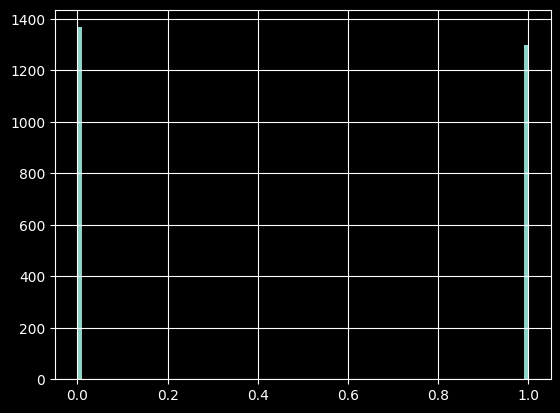

In [8]:
labels['blur'].hist(bins=100);

#### 1.2.3 Checking the target value for missing and duplicates

In [9]:
labels.isna().sum()

filename    0
blur        0
dtype: int64

In [10]:
labels.duplicated().sum()

0

#### 1.2.4  Checking the target value for disbalance

In [11]:
labels_df = pd.DataFrame(labels)

In [12]:
labels_df['blur'].value_counts()

0.0    1367
1.0    1297
Name: blur, dtype: int64

In [13]:
train_blur = labels[labels["blur"]==1]
train_sharp = labels[labels["blur"]==0]

print("Blur images:", len(train_blur))
print("Sharp images:", len(train_sharp))

Blur images: 1297
Sharp images: 1367


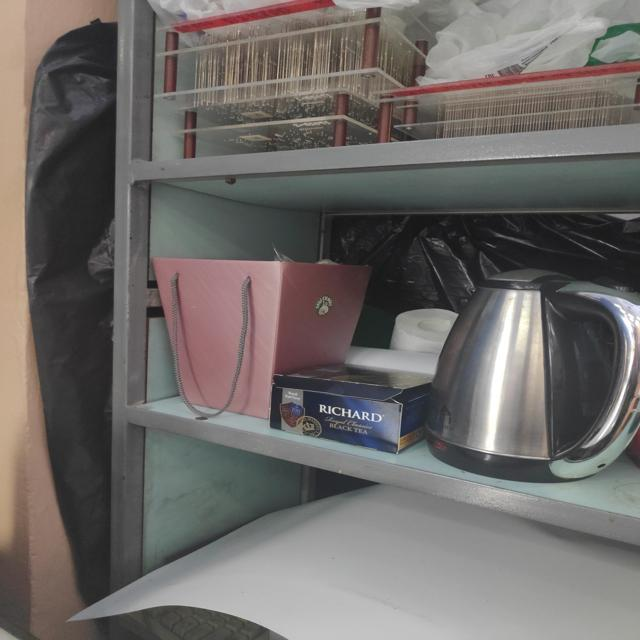

In [14]:
img = Image.open('/Users/yuliabezginova/PycharmProjects/00_files-for_NLP/shift-cv-winter-2023/train/train/aaashhimmhraddpwwizz.jpg')
img

### ***Conclusion:*** Type of variable in the target values is ```float64``` with two unique values - 0, 1. This is fine for solving classification problem, but the target should be converted into ```string``` type. Number of observations if 2664. The target dataset is balanced.

# 2 Laplacian Algorithm for Blurred Image Detection

In [15]:
def variance_of_laplacian_blur(image, threshold):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    result = cv2.Laplacian(image, cv2.CV_64F).var()
    print(f' Laplacian result: {result}')
    if result < threshold:
        return 1
    else:
        return 0

In [16]:
def create_dataframe(path_folder: str, threshold):
    df_map = {'filename':[], 'blur':[]}
    filenames = [f for f in os.listdir(path_folder) if os.path.isfile(os.path.join(path_folder, f))]
    for file in filenames: #type: str
        if 'jpg' in file or 'png' in file or 'jpeg' in file or 'JPG' in file:
            full_image_path = os.path.join(path_folder,file)
            image_array = cv2.imread(full_image_path)
            result = variance_of_laplacian_blur(image_array, threshold)
            print(f'img {file}: laplacian: {result}')
            df_map['filename'].append(file)
            df_map['blur'].append(result)
    df = pd.DataFrame(df_map)
    return df

In [17]:
result_laplacian = create_dataframe('/Users/yuliabezginova/PycharmProjects/00_files-for_NLP/shift-cv-winter-2023/test/test/', 280)

 Laplacian result: 144.1267429028724
img fypnbvdjytoeycwfkbof.jpg: laplacian: 1
 Laplacian result: 82.52970354493195
img uvrujzuyrklrsokmgmnc.jpg: laplacian: 1
 Laplacian result: 39.3832191655371
img oxvalbmdruepdvalmovq.jpg: laplacian: 1
 Laplacian result: 148.7216447243366
img rdqmlrqscqxevtllbwpl.jpg: laplacian: 1
 Laplacian result: 179.5767709256006
img oqpwiybzirgxxxlbvrag.jpg: laplacian: 1
 Laplacian result: 70.23772423931692
img fzlcmpfpfqymcngmwgwg.jpg: laplacian: 1
 Laplacian result: 603.924071592712
img turudimbdmpzwxilfnwj.jpg: laplacian: 0
 Laplacian result: 290.45852686021334
img ejgrodzlnaxwirnyjvfu.jpg: laplacian: 0
 Laplacian result: 55.5151970689237
img fbjnxsvpqgnvumdbupcg.jpg: laplacian: 1
 Laplacian result: 21.133845985918587
img srldvfcqyidfrxuzital.jpg: laplacian: 1
 Laplacian result: 319.27312425244577
img tyueqyhoxyuzcjbqrwmh.jpg: laplacian: 0
 Laplacian result: 187.8813577446833
img eaufgfyvsgpqypnspety.jpg: laplacian: 1
 Laplacian result: 395.5150510911406
img

 Laplacian result: 66.08039617625805
img mkmhaaosbwlgecjjlfdf.jpg: laplacian: 1
 Laplacian result: 705.5491457156174
img brhkskjxaltuplkduekb.jpg: laplacian: 0
 Laplacian result: 152.79061120112738
img taigfzgimihtnfmbukho.jpg: laplacian: 1
 Laplacian result: 29.12899397637846
img dufxhphtkcneaaxcoqlf.jpg: laplacian: 1
 Laplacian result: 269.1517293197308
img rotatyptdlbhvgylappa.jpg: laplacian: 1
 Laplacian result: 441.2371985053956
img jmghndwmnudlrgvzaevh.jpg: laplacian: 0
 Laplacian result: 330.23125085287023
img fwtbtncwdmsrwwtgkiim.jpg: laplacian: 0
 Laplacian result: 210.81252195755576
img jdefdmnjbtkdzjyzgaqt.jpg: laplacian: 1
 Laplacian result: 309.5730009934365
img lnhouaiubslildofoiax.jpg: laplacian: 0
 Laplacian result: 754.4148551219776
img xebxsspphsjplkvhdohw.jpg: laplacian: 0
 Laplacian result: 654.2005921051492
img jdscczvurbvtqmnwamlg.jpg: laplacian: 0
 Laplacian result: 195.2998899777624
img mgfhevufmcljirfvsjet.jpg: laplacian: 1
 Laplacian result: 71.169472123758
im

 Laplacian result: 245.1947577152224
img zbxijoomsigvensfsiid.jpg: laplacian: 1
 Laplacian result: 236.03363259732723
img ahqjkaowvephhufdlvgu.jpg: laplacian: 1
 Laplacian result: 31.461424388471556
img vhbaucfjdvrxickkdhdo.jpg: laplacian: 1
 Laplacian result: 53.20846245063078
img rarwedwkgivamorvmpbq.jpg: laplacian: 1
 Laplacian result: 91.46025762378909
img kezsqmyyirxeoicxlevz.jpg: laplacian: 1
 Laplacian result: 649.2464127660086
img dzfpznizsensebcwkjyb.jpg: laplacian: 0
 Laplacian result: 64.6039390294545
img xsnxudwrofdmiccxkbtc.jpg: laplacian: 1
 Laplacian result: 1639.1076241977842
img oylpywpwgobocnawyaed.jpg: laplacian: 0
 Laplacian result: 180.75903539971242
img nlhaguxtuyibykuvvzpd.jpg: laplacian: 1
 Laplacian result: 128.8204378335946
img oyiqmplsgivhxcrlsgio.jpg: laplacian: 1
 Laplacian result: 18.80040884691808
img myaztmrrbqishxqbcgdi.jpg: laplacian: 1
 Laplacian result: 401.27231871313444
img ppuoksjdrsqkusnzqsnk.jpg: laplacian: 0
 Laplacian result: 194.4011294047038

 Laplacian result: 105.63596141738624
img tampppyippgqlukisrji.jpg: laplacian: 1
 Laplacian result: 1044.8736925720214
img xovtrlfcjwaqoemypbdb.jpg: laplacian: 0
 Laplacian result: 745.9242729122773
img hdgidhdwjosysbsmidtm.jpg: laplacian: 0
 Laplacian result: 104.40031324207511
img kugcowedbiowoalfjzmr.jpg: laplacian: 1
 Laplacian result: 34.78573796653681
img wjewerjwdylemrdfxygh.jpg: laplacian: 1
 Laplacian result: 521.4773744625351
img ixbswtabzyczzarfwavr.jpg: laplacian: 0
 Laplacian result: 243.0888080878548
img hynogkqncsbbwrdrmnjy.jpg: laplacian: 1
 Laplacian result: 1599.4089690333037
img wvkokgwubjwuukitdrst.jpg: laplacian: 0
 Laplacian result: 107.64335117406254
img yjlqzcypxrisycpzzzgr.jpg: laplacian: 1
 Laplacian result: 165.53193737482425
img dxhxlumnlgqzuafvxhax.jpg: laplacian: 1
 Laplacian result: 565.9421838838358
img cjqeuthfgwbenhxwjquz.jpg: laplacian: 0
 Laplacian result: 109.27225745550524
img fhfjnywssiddywpgcjec.jpg: laplacian: 1
 Laplacian result: 11.37535007264

 Laplacian result: 54.29427078993055
img snmsfhhflrbuquytirqu.jpg: laplacian: 1
 Laplacian result: 60.60548451084297
img bokvyndjthzntknxaezo.jpg: laplacian: 1
 Laplacian result: 24.897291094048164
img mtauwiyubyuqfnagayaz.jpg: laplacian: 1
 Laplacian result: 47.376123904778545
img pedazzvqyytjhpduouvo.jpg: laplacian: 1
 Laplacian result: 68.58366878055934
img fqsrdzvgishrtfklhwik.jpg: laplacian: 1
 Laplacian result: 272.7556846920483
img zfsncsynizjpfbuwrypp.jpg: laplacian: 1
 Laplacian result: 1292.1056069013287
img vcklrzpxtpbtdqkewofr.jpg: laplacian: 0
 Laplacian result: 948.7017607181012
img cvwxlwpccxcxaiiityxt.jpg: laplacian: 0
 Laplacian result: 592.3133232570958
img uuzcwdbxcvhwvdqypala.jpg: laplacian: 0
 Laplacian result: 258.00281081186336
img dsiduhbvpixxvycobvdl.jpg: laplacian: 1
 Laplacian result: 126.55900880619616
img ejfwkjphvcwturrelqon.jpg: laplacian: 1
 Laplacian result: 114.43239893489418
img vxkvkimlynqoirsbhbel.jpg: laplacian: 1
 Laplacian result: 1130.6819933063

 Laplacian result: 641.5488405863437
img yusmlkweyessdukglrgk.jpg: laplacian: 0
 Laplacian result: 244.74345285733258
img ripbazdlcizcxqppvwnk.jpg: laplacian: 1
 Laplacian result: 10.536475390830969
img gasrcbfrhcdhtriwjcvk.jpg: laplacian: 1
 Laplacian result: 348.3808902533213
img takfibxfjsqrcionbhuf.jpg: laplacian: 0
 Laplacian result: 214.50903816322472
img wthagqhnzfuwstaxcwya.jpg: laplacian: 1
 Laplacian result: 285.78215646635425
img rkhqlpojvtyxeircfmnt.jpg: laplacian: 0
 Laplacian result: 122.11213423687558
img wyacqmyjcqhqawomulco.jpg: laplacian: 1
 Laplacian result: 55.16493111131921
img jkihrcpxymyoomwlhrvv.jpg: laplacian: 1
 Laplacian result: 146.65366041819183
img blamwtalsacrzqkdzgwp.jpg: laplacian: 1
 Laplacian result: 1017.288548240979
img adicqesamknapclvcesb.jpg: laplacian: 0
 Laplacian result: 133.89217466989092
img qhhpekntxvggqqrjeezu.jpg: laplacian: 1
 Laplacian result: 443.52054982256794
img fbgjjylockhoqblodqse.jpg: laplacian: 0
 Laplacian result: 690.866533355

 Laplacian result: 212.339544287967
img xgrcgucfvphduvgsmcms.jpg: laplacian: 1
 Laplacian result: 50.57895322619278
img bmlfgszjiysqfvrpqrex.jpg: laplacian: 1
 Laplacian result: 32.18119909022651
img iducvyouevsurwjhtvkb.jpg: laplacian: 1
 Laplacian result: 342.7544699853658
img gnzcgtsidisvvtrdewbl.jpg: laplacian: 0
 Laplacian result: 497.2852144653292
img eksgeyzhslmsgmoqgbdt.jpg: laplacian: 0
 Laplacian result: 165.16446748707017
img ofwdruessnujzqjexyei.jpg: laplacian: 1
 Laplacian result: 597.0904605719013
img fxpvrfcoeuaxqvzmqrxg.jpg: laplacian: 0
 Laplacian result: 126.94865829848177
img mnegexrnjhqiezxgxhqh.jpg: laplacian: 1
 Laplacian result: 159.51971311136825
img avgbkpxmnbhcwsefrfkg.jpg: laplacian: 1
 Laplacian result: 1333.0961404739764
img xpuexjkoopucdokdagqr.jpg: laplacian: 0
 Laplacian result: 12.763595576816122
img vqeecepjmhsmfnpgftkz.jpg: laplacian: 1
 Laplacian result: 708.8266165012114
img fmctwlvtywbxudwagxke.jpg: laplacian: 0
 Laplacian result: 294.2762964281611

 Laplacian result: 92.74579335424627
img hdjerfhchodobzwjiotu.jpg: laplacian: 1
 Laplacian result: 701.5757604539234
img puffrdoqktbmqmfdwvln.jpg: laplacian: 0
 Laplacian result: 201.58496782158747
img xjzibwpysqxflunnzfoi.jpg: laplacian: 1
 Laplacian result: 445.1421401020449
img slyhtrmmtgesklplvmsh.jpg: laplacian: 0
 Laplacian result: 53.295034515841095
img brwxdhouysdqzpaellci.jpg: laplacian: 1
 Laplacian result: 427.351168236245
img zdmnhnzsvaacogxplrtk.jpg: laplacian: 0
 Laplacian result: 277.7580901533862
img fombbxrgcpycyjfqtgta.jpg: laplacian: 1
 Laplacian result: 102.0026156513188
img qhidvpjjnvoiosfthzsu.jpg: laplacian: 1
 Laplacian result: 886.3529733649256
img oxvomhuybxqqyzuvjmlc.jpg: laplacian: 0
 Laplacian result: 209.29213924963665
img oqxcfxggunvdlkqgfewi.jpg: laplacian: 1
 Laplacian result: 28.72826780318948
img cutxyylipojsjoidymvy.jpg: laplacian: 1
 Laplacian result: 16.6960313542578
img qkbbjxtyvwctdyrlvyit.jpg: laplacian: 1
 Laplacian result: 248.4160786800358
im

In [18]:
result_laplacian.to_csv('/Users/yuliabezginova/PycharmProjects/CV_02_BlurredImagesDetection/result_laplacian.csv', index=False)

In [19]:
test_pred_laplacian = pd.read_csv('/Users/yuliabezginova/PycharmProjects/CV_02_BlurredImagesDetection/result_laplacian.csv')
test_pred_laplacian.head(7)

filename  blur
0  fypnbvdjytoeycwfkbof.jpg     1
1  uvrujzuyrklrsokmgmnc.jpg     1
2  oxvalbmdruepdvalmovq.jpg     1
3  rdqmlrqscqxevtllbwpl.jpg     1
4  oqpwiybzirgxxxlbvrag.jpg     1
5  fzlcmpfpfqymcngmwgwg.jpg     1
6  turudimbdmpzwxilfnwj.jpg     0

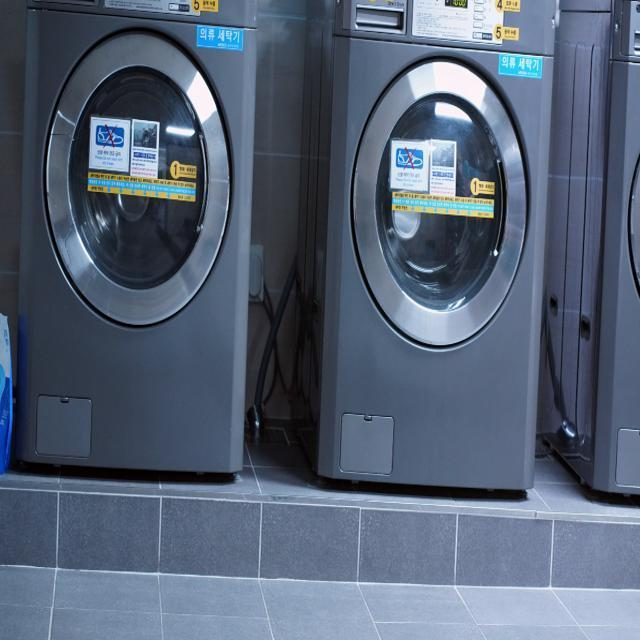

In [20]:
# manual testing - correct, 0=sharp
img_test = Image.open('/Users/yuliabezginova/PycharmProjects/00_files-for_NLP/shift-cv-winter-2023/test/test/turudimbdmpzwxilfnwj.jpg')
img_test

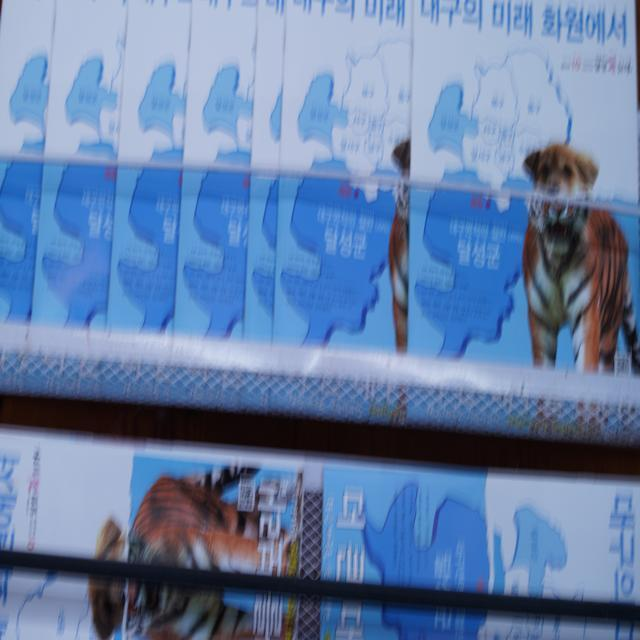

In [21]:
# manual testing - correct, 1=blurred
img_test = Image.open('/Users/yuliabezginova/PycharmProjects/00_files-for_NLP/shift-cv-winter-2023/test/test/uvrujzuyrklrsokmgmnc.jpg')
img_test

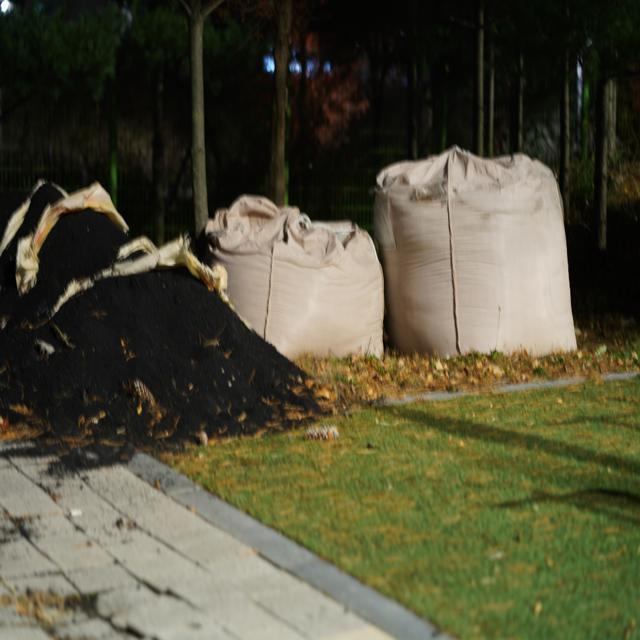

In [22]:
# manual testing - correct, 1=blurred
img_test = Image.open('/Users/yuliabezginova/PycharmProjects/00_files-for_NLP/shift-cv-winter-2023/test/test/rdqmlrqscqxevtllbwpl.jpg')
img_test

# 3 Fitting the CNN models

## 3.1 Defining the function for loading the data, initiating and training a model

Data augmentation is used to prevent overfitting.

In [23]:
path = '/Users/yuliabezginova/PycharmProjects/00_files-for_NLP/shift-cv-winter-2023/'

In [24]:
def load_train(path):
    labels = pd.read_csv(path + 'train.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'train/train/',
        x_col='filename',
        y_col='blur',
        target_size=(96, 96),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=5)

    return train_gen_flow


def load_test(path):
    labels = pd.read_csv(path + 'train.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'train/train/',
        x_col='filename',
        y_col='blur',
        target_size=(96, 96),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=5)

    return test_gen_flow

In [25]:
train = load_train(path)

Found 1998 validated image filenames.


In [26]:
valid = load_test(path)

Found 666 validated image filenames.


In [27]:
from tensorflow.keras.applications.resnet import ResNet50

In [28]:
def create_model(input_shape):
    model = Sequential()
#     model.add(layers.Reshape((96, 96, 2), input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
#     model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
#     model.add(BatchNormalization())
    model.add(Flatten())    
    model.add(Dense(10))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
#     model.add(BatchNormalization())
    model.add(Dense(1, activation='softmax'))
    
    optimizer = Adam(learning_rate=0.0001)
    
    model.compile(optimizer, loss = "categorical_crossentropy",
                  metrics=['accuracy'])
    return model

In [29]:
# def train_model(model, train_data, test_data, batch_size=None, epochs=30,
#                 steps_per_epoch=None, validation_steps=None):

#     if steps_per_epoch is None:
#         steps_per_epoch = len(train_data)
#     if validation_steps is None:
#         validation_steps = len(test_data)

#     model.fit(train_data,
#               validation_data=test_data,
#               batch_size=batch_size,
#               epochs=epochs,
#               steps_per_epoch=steps_per_epoch,
#               validation_steps=validation_steps,
#               verbose=2)

#     return model

### ***Conclusion:*** The functions for loading train and validation samples, creating and training the models are written, we can proceed with tuning different CNNs.

## 3.2 Creating and training different CNNs

In the CNN structure we add Dropout() regularization and BatchNormalization() layers.

- **BatchNormalization()** normalizes the activations of the previous layer at each batch, by subtracting the batch mean and dividing by the batch standard deviation. This helps to stabilize the learning process and allow higher learning rates, as well as reducing the chances of the model getting stuck in the saddle points or local optima.

- **Dropout()** is a regularization technique where some neurons are randomly dropped out during training. This helps to reduce overfitting by preventing complex co-adaptations on training data. The dropout rate is the fraction of neurons that are dropped out, usually between 0.2 and 0.5. At test time, no neurons are dropped out, but the weights are scaled by the dropout rate to balance the effect of missing neurons.

In [30]:
input_shape = (96, 96, 3)

In [31]:
STEP_SIZE_TRAIN=train.n//train.batch_size
STEP_SIZE_VALID=valid.n//valid.batch_size

- Model 1

In [32]:
# Initiating the model
model = create_model(input_shape)

2023-02-21 13:12:18.672232: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [33]:
# %%time
# # training the model
# history = train_model(model, 
#                         train,
#                         valid, 
#                         batch_size=5, 
#                         epochs=5, 
#                         steps_per_epoch=STEP_SIZE_TRAIN, 
#                         validation_steps=STEP_SIZE_VALID)

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 64)        1792      
                                                                 
 activation (Activation)     (None, 96, 96, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 94, 94, 32)        18464     
                                                                 
 activation_1 (Activation)   (None, 94, 94, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 47, 47, 32)        0         
                                                        

In [ ]:
%%time
history = model.fit_generator(train,
          validation_data=valid,
          epochs=30,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_steps=STEP_SIZE_VALID,
          verbose=2)

Epoch 1/30
62/62 - 67s - loss: 0.0000e+00 - accuracy: 0.4847 - val_loss: 0.0000e+00 - val_accuracy: 0.4953 - 67s/epoch - 1s/step
Epoch 2/30
62/62 - 60s - loss: 0.0000e+00 - accuracy: 0.4863 - val_loss: 0.0000e+00 - val_accuracy: 0.4969 - 60s/epoch - 970ms/step
Epoch 3/30
62/62 - 76s - loss: 0.0000e+00 - accuracy: 0.4852 - val_loss: 0.0000e+00 - val_accuracy: 0.4906 - 76s/epoch - 1s/step
Epoch 4/30
62/62 - 111s - loss: 0.0000e+00 - accuracy: 0.4852 - val_loss: 0.0000e+00 - val_accuracy: 0.4922 - 111s/epoch - 2s/step
Epoch 5/30
62/62 - 95s - loss: 0.0000e+00 - accuracy: 0.4878 - val_loss: 0.0000e+00 - val_accuracy: 0.4859 - 95s/epoch - 2s/step
Epoch 6/30
62/62 - 82s - loss: 0.0000e+00 - accuracy: 0.4852 - val_loss: 0.0000e+00 - val_accuracy: 0.4906 - 82s/epoch - 1s/step
Epoch 7/30
62/62 - 64s - loss: 0.0000e+00 - accuracy: 0.4852 - val_loss: 0.0000e+00 - val_accuracy: 0.4969 - 64s/epoch - 1s/step
Epoch 8/30
62/62 - 99s - loss: 0.0000e+00 - accuracy: 0.4858 - val_loss: 0.0000e+00 - val_ac

- Model 2

In [78]:
def create_model_ResNet50(input_shape):    
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    
#     замораживаем ResNet50 без верхушки
#     backbone.trainable = False

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.25))
#     model.add(BatchNormalization())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='softmax')) 

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss = "binary_crossentropy",
                  metrics=['accuracy'])

    return model

In [79]:
# Initiating the model
model2 = create_model_ResNet50(input_shape)

In [81]:
model2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_10 (Dropout)        (None, 2048)              0         
                                                                 
 dense_13 (Dense)            (None, 32)                65568     
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 23,653,313
Trainable params: 23,600,193
Non-trainable params: 53,120
_____________________________________

In [82]:
%%time
history2 = model2.fit_generator(train,
          validation_data=valid,
          epochs=10,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_steps=STEP_SIZE_VALID,
          verbose=2)

Epoch 1/10
62/62 - 311s - loss: 0.6489 - accuracy: 0.4852 - val_loss: 0.6946 - val_accuracy: 0.4984 - 311s/epoch - 5s/step
Epoch 2/10
62/62 - 276s - loss: 0.2723 - accuracy: 0.4863 - val_loss: 2.0033 - val_accuracy: 0.4906 - 276s/epoch - 4s/step
Epoch 3/10
62/62 - 396s - loss: 0.1968 - accuracy: 0.4852 - val_loss: 0.6918 - val_accuracy: 0.4906 - 396s/epoch - 6s/step
Epoch 4/10
62/62 - 261s - loss: 0.1485 - accuracy: 0.4827 - val_loss: 1.4749 - val_accuracy: 0.5000 - 261s/epoch - 4s/step
Epoch 5/10
62/62 - 262s - loss: 0.1094 - accuracy: 0.4847 - val_loss: 3.5261 - val_accuracy: 0.4938 - 262s/epoch - 4s/step
Epoch 6/10
62/62 - 263s - loss: 0.0962 - accuracy: 0.4847 - val_loss: 0.8395 - val_accuracy: 0.4938 - 263s/epoch - 4s/step
Epoch 7/10
62/62 - 259s - loss: 0.1016 - accuracy: 0.4852 - val_loss: 0.6369 - val_accuracy: 0.4938 - 259s/epoch - 4s/step
Epoch 8/10
62/62 - 264s - loss: 0.0665 - accuracy: 0.4837 - val_loss: 0.5900 - val_accuracy: 0.4984 - 264s/epoch - 4s/step
Epoch 9/10
62/62

- Model 3

In [85]:
# Ruba's CNN
def create_model_3(input_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(2, 2), activation ='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization()) # added
    model.add(Conv2D(64, kernel_size = (2,2), activation ='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization()) # added
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=0.0001) # updated to lr=0.0001

    model.compile(loss = "binary_crossentropy", 
              optimizer=optimizer, metrics=['accuracy'])
    return model

In [86]:
# Initiating the model
model3 = create_model_3(input_shape)

In [87]:
# # training the model
# model_3 = train_model(model_3, 
#                         train,
#                         valid, 
#                         batch_size=32, 
#                         epochs=50, 
#                         steps_per_epoch=STEP_SIZE_TRAIN, 
#                         validation_steps=STEP_SIZE_VALID)

In [88]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 96, 96, 64)        1792      
                                                                 
 activation_3 (Activation)   (None, 96, 96, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 94, 94, 32)        18464     
                                                                 
 activation_4 (Activation)   (None, 94, 94, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 47, 47, 32)        0         
                                                      

In [89]:
%%time
history3 = model3.fit_generator(train,
          validation_data=valid,
          epochs=30,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_steps=STEP_SIZE_VALID,
          verbose=2)

Epoch 1/30
62/62 - 26s - loss: 0.7153 - accuracy: 0.6506 - val_loss: 0.7227 - val_accuracy: 0.4875 - 26s/epoch - 421ms/step
Epoch 2/30
62/62 - 22s - loss: 0.4453 - accuracy: 0.8098 - val_loss: 0.7172 - val_accuracy: 0.5469 - 22s/epoch - 357ms/step
Epoch 3/30
62/62 - 22s - loss: 0.3542 - accuracy: 0.8484 - val_loss: 0.7319 - val_accuracy: 0.5609 - 22s/epoch - 358ms/step
Epoch 4/30
62/62 - 22s - loss: 0.2935 - accuracy: 0.8866 - val_loss: 0.7075 - val_accuracy: 0.6000 - 22s/epoch - 358ms/step
Epoch 5/30
62/62 - 22s - loss: 0.2543 - accuracy: 0.8952 - val_loss: 1.0312 - val_accuracy: 0.5813 - 22s/epoch - 361ms/step
Epoch 6/30
62/62 - 22s - loss: 0.2124 - accuracy: 0.9207 - val_loss: 1.0157 - val_accuracy: 0.6094 - 22s/epoch - 356ms/step
Epoch 7/30
62/62 - 22s - loss: 0.1980 - accuracy: 0.9288 - val_loss: 1.3019 - val_accuracy: 0.5828 - 22s/epoch - 355ms/step
Epoch 8/30
62/62 - 22s - loss: 0.1816 - accuracy: 0.9359 - val_loss: 0.9672 - val_accuracy: 0.6594 - 22s/epoch - 356ms/step
Epoch 9/

- Model 4

In [91]:
def create_model_4(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3),
                     input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3)))
#     model.add(Activation('relu'))
#     model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization()) # added
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(1, activation='softmax'))

    optimizer = Adam(learning_rate=0.0001) # updated to lr=0.0001
    model.compile(optimizer=optimizer, 
                  loss="binary_crossentropy", 
              metrics=["accuracy"])
    return model

In [92]:
%%time
# Initiating the model
model4 = create_model_4(input_shape)

# # training the model
# model_4 = train_model(model_4, 
#                         train,
#                         valid, 
#                         batch_size=16, 
#                         epochs=3, 
#                         steps_per_epoch=STEP_SIZE_TRAIN, 
#                         validation_steps=STEP_SIZE_VALID)

CPU times: user 117 ms, sys: 4.95 ms, total: 122 ms
Wall time: 124 ms


In [93]:
model4.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 activation_8 (Activation)   (None, 94, 94, 32)        0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 47, 47, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 activation_9 (Activation)   (None, 45, 45, 64)        0         
                                                      

In [95]:
%%time
history4 = model4.fit_generator(train,
          validation_data=valid,
          epochs=30,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_steps=STEP_SIZE_VALID,
          verbose=2)

Epoch 1/30
62/62 - 28s - loss: 0.7997 - accuracy: 0.4873 - val_loss: 0.6860 - val_accuracy: 0.4922 - 28s/epoch - 452ms/step
Epoch 2/30
62/62 - 26s - loss: 0.7100 - accuracy: 0.4863 - val_loss: 0.6785 - val_accuracy: 0.4922 - 26s/epoch - 415ms/step
Epoch 3/30
62/62 - 27s - loss: 0.6462 - accuracy: 0.4827 - val_loss: 0.6596 - val_accuracy: 0.4922 - 27s/epoch - 431ms/step
Epoch 4/30
62/62 - 27s - loss: 0.6249 - accuracy: 0.4827 - val_loss: 0.6506 - val_accuracy: 0.4953 - 27s/epoch - 434ms/step
Epoch 5/30
62/62 - 26s - loss: 0.5948 - accuracy: 0.4863 - val_loss: 0.6283 - val_accuracy: 0.4953 - 26s/epoch - 423ms/step
Epoch 6/30
62/62 - 27s - loss: 0.5670 - accuracy: 0.4863 - val_loss: 0.6220 - val_accuracy: 0.4875 - 27s/epoch - 436ms/step
Epoch 7/30
62/62 - 26s - loss: 0.5297 - accuracy: 0.4847 - val_loss: 0.6386 - val_accuracy: 0.4891 - 26s/epoch - 422ms/step
Epoch 8/30
62/62 - 27s - loss: 0.5024 - accuracy: 0.4863 - val_loss: 0.8022 - val_accuracy: 0.4922 - 27s/epoch - 437ms/step
Epoch 9/

- Model 5

In [104]:
def create_model_5(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.25)) # regularization
    
    model.add(BatchNormalization()) # added
#     model.add(Conv2D(64, (3, 3), padding='same'))
#     model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.25)) # regularization
    
    model.add(BatchNormalization()) # added
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='Adamax', 
                  loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [99]:
# Initiating the model
model5 = create_model_5(input_shape)

# # training the model
# model5 = train_model(model_5, 
#                         train,
#                         valid, 
#                         batch_size=32, 
#                         epochs=50, 
#                         steps_per_epoch=STEP_SIZE_TRAIN, 
#                         validation_steps=STEP_SIZE_VALID)

In [100]:
model5.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 activation_10 (Activation)  (None, 96, 96, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 94, 94, 32)        9248      
                                                                 
 activation_11 (Activation)  (None, 94, 94, 32)        0         
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 47, 47, 32)        0         
                                                     

In [101]:
%%time
history5 = model5.fit_generator(train,
          validation_data=valid,
          epochs=30,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_steps=STEP_SIZE_VALID,
          verbose=2)

Epoch 1/30
62/62 - 50s - loss: 0.8692 - accuracy: 0.5941 - val_loss: 0.6823 - val_accuracy: 0.5469 - 50s/epoch - 806ms/step
Epoch 2/30
62/62 - 50s - loss: 0.6595 - accuracy: 0.7019 - val_loss: 0.6917 - val_accuracy: 0.5125 - 50s/epoch - 803ms/step
Epoch 3/30
62/62 - 51s - loss: 0.5049 - accuracy: 0.7721 - val_loss: 1.1316 - val_accuracy: 0.5078 - 51s/epoch - 822ms/step
Epoch 4/30
62/62 - 52s - loss: 0.5233 - accuracy: 0.7803 - val_loss: 1.9019 - val_accuracy: 0.5000 - 52s/epoch - 845ms/step
Epoch 5/30
62/62 - 51s - loss: 0.4122 - accuracy: 0.8286 - val_loss: 2.1359 - val_accuracy: 0.5094 - 51s/epoch - 816ms/step
Epoch 6/30
62/62 - 48s - loss: 0.4112 - accuracy: 0.8316 - val_loss: 1.6988 - val_accuracy: 0.5047 - 48s/epoch - 778ms/step
Epoch 7/30
62/62 - 49s - loss: 0.3627 - accuracy: 0.8555 - val_loss: 1.5873 - val_accuracy: 0.5172 - 49s/epoch - 787ms/step
Epoch 8/30
62/62 - 50s - loss: 0.3486 - accuracy: 0.8571 - val_loss: 1.3430 - val_accuracy: 0.5437 - 50s/epoch - 803ms/step
Epoch 9/

In [114]:
%%time
history6 = model5.fit_generator(train,
          validation_data=valid,
          epochs=50,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_steps=STEP_SIZE_VALID,
          verbose=2)

Epoch 1/50
62/62 - 48s - loss: 0.1335 - accuracy: 0.9471 - val_loss: 0.4296 - val_accuracy: 0.8313 - 48s/epoch - 771ms/step
Epoch 2/50
62/62 - 47s - loss: 0.1329 - accuracy: 0.9466 - val_loss: 0.4535 - val_accuracy: 0.8828 - 47s/epoch - 751ms/step
Epoch 3/50
62/62 - 47s - loss: 0.1291 - accuracy: 0.9481 - val_loss: 0.3177 - val_accuracy: 0.8922 - 47s/epoch - 757ms/step
Epoch 4/50
62/62 - 46s - loss: 0.1158 - accuracy: 0.9603 - val_loss: 0.4513 - val_accuracy: 0.8609 - 46s/epoch - 749ms/step
Epoch 5/50
62/62 - 48s - loss: 0.1163 - accuracy: 0.9598 - val_loss: 0.3251 - val_accuracy: 0.8750 - 48s/epoch - 776ms/step
Epoch 6/50
62/62 - 47s - loss: 0.1260 - accuracy: 0.9563 - val_loss: 0.3642 - val_accuracy: 0.8813 - 47s/epoch - 751ms/step
Epoch 7/50
62/62 - 47s - loss: 0.1121 - accuracy: 0.9552 - val_loss: 0.3994 - val_accuracy: 0.8531 - 47s/epoch - 755ms/step
Epoch 8/50
62/62 - 50s - loss: 0.1305 - accuracy: 0.9486 - val_loss: 0.3404 - val_accuracy: 0.8938 - 50s/epoch - 807ms/step
Epoch 9/

In [118]:
%%time
history7 = model5.fit_generator(train,
          validation_data=valid,
          epochs=100,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_steps=STEP_SIZE_VALID,
          verbose=1)

Epoch 1/100
62/62 [==============================] - 47s 760ms/step - loss: 0.0631 - accuracy: 0.9786 - val_loss: 0.3663 - val_accuracy: 0.9000
Epoch 2/100
62/62 [==============================] - 47s 755ms/step - loss: 0.0452 - accuracy: 0.9832 - val_loss: 0.6197 - val_accuracy: 0.8313
Epoch 3/100
62/62 [==============================] - 47s 759ms/step - loss: 0.0504 - accuracy: 0.9814 - val_loss: 0.4083 - val_accuracy: 0.8875
Epoch 4/100
62/62 [==============================] - 47s 761ms/step - loss: 0.0919 - accuracy: 0.9664 - val_loss: 0.4574 - val_accuracy: 0.8813
Epoch 5/100
62/62 [==============================] - 47s 762ms/step - loss: 0.0401 - accuracy: 0.9868 - val_loss: 0.5092 - val_accuracy: 0.8875
Epoch 6/100
62/62 [==============================] - 49s 781ms/step - loss: 0.0517 - accuracy: 0.9829 - val_loss: 0.3798 - val_accuracy: 0.8734
Epoch 7/100
62/62 [==============================] - 53s 853ms/step - loss: 0.0504 - accuracy: 0.9791 - val_loss: 0.3734 - val_accuracy:

## 3.3 Choosing the best CNN model

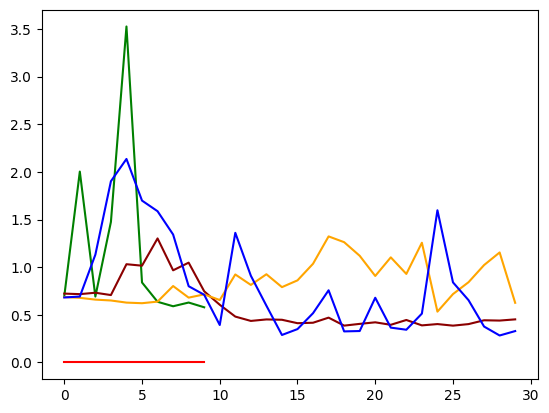

In [121]:
plt.plot(history.history['val_loss'], 'r', 
         history2.history['val_loss'], 'g', 
         history3.history['val_loss'], 'darkred', 
         history4.history['val_loss'], 'orange', 
         history5.history['val_loss'], 'b');

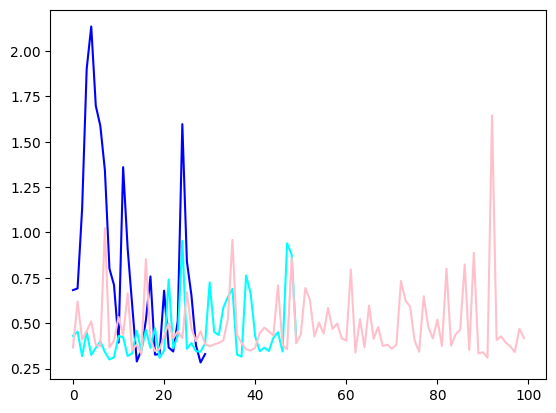

In [122]:
plt.plot(history5.history['val_loss'], 'b',
         history6.history['val_loss'], 'cyan',
         history7.history['val_loss'], 'pink');

- **Model 1 - CNN**

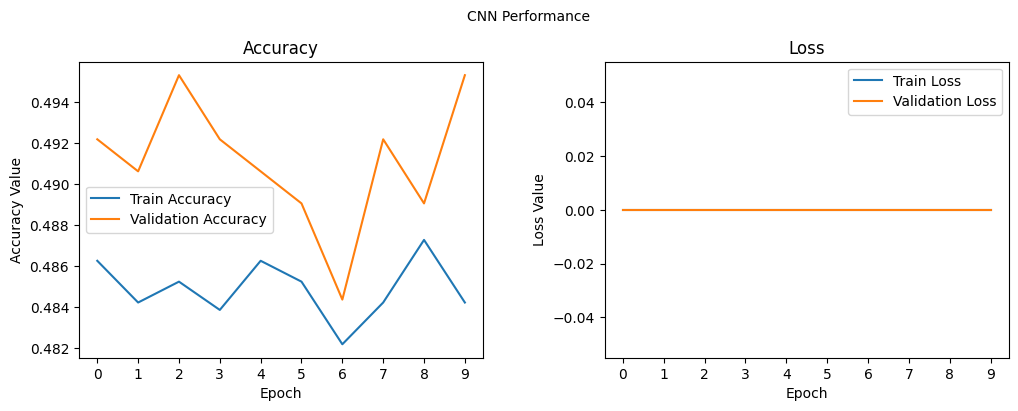

In [109]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN Performance', fontsize=10)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(0, 10))

ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')

ax1.set_xticks(np.arange(0, 10, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 10, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [110]:
# plt.plot(history.history['accuracy'], label='acc', color='red')
# plt.plot(history.history['val_accuracy'], label='val_acc', color='darkblue')
# plt.legend();

- **Model 2 - ResNet50**

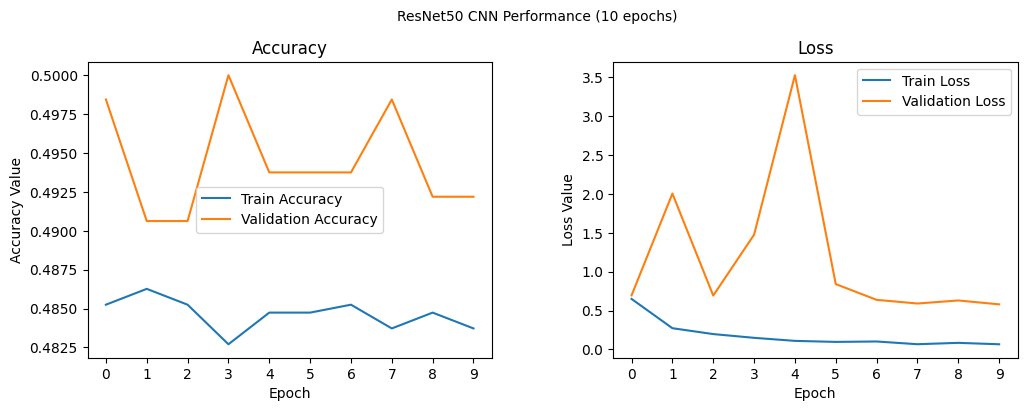

In [111]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('ResNet50 CNN Performance (10 epochs)', fontsize=10)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(0, 10))
ax1.plot(epoch_list, history2.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history2.history['val_accuracy'], label='Validation Accuracy')

ax1.set_xticks(np.arange(0, 10, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history2.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history2.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 10, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

- **Model 3 - CNN**

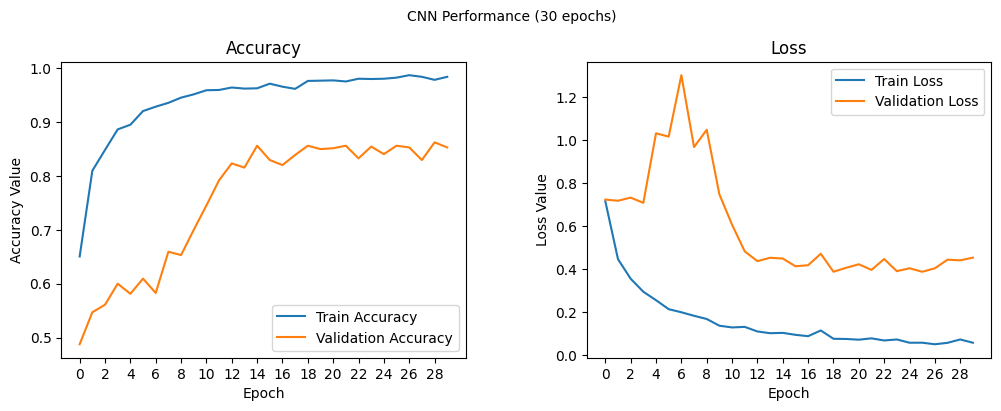

In [112]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN #5 Performance (30 epochs)', fontsize=10)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(0, 30))
ax1.plot(epoch_list, history3.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history3.history['val_accuracy'], label='Validation Accuracy')

ax1.set_xticks(np.arange(0, 30, 2))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history3.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history3.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 30, 2))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

- **Model 4 CNN**

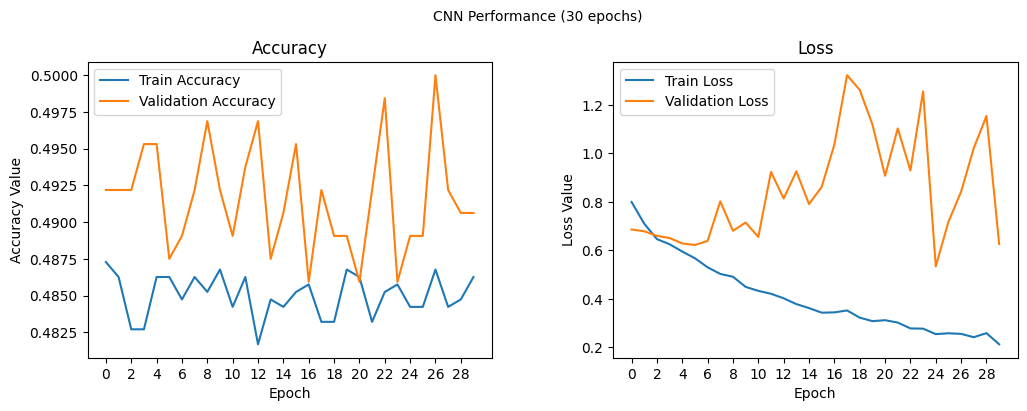

In [113]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN #4 Performance (30 epochs)', fontsize=10)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(0, 30))
ax1.plot(epoch_list, history4.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history4.history['val_accuracy'], label='Validation Accuracy')

ax1.set_xticks(np.arange(0, 30, 2))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history4.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history4.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 30, 2))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

- **Model 5 CNN**

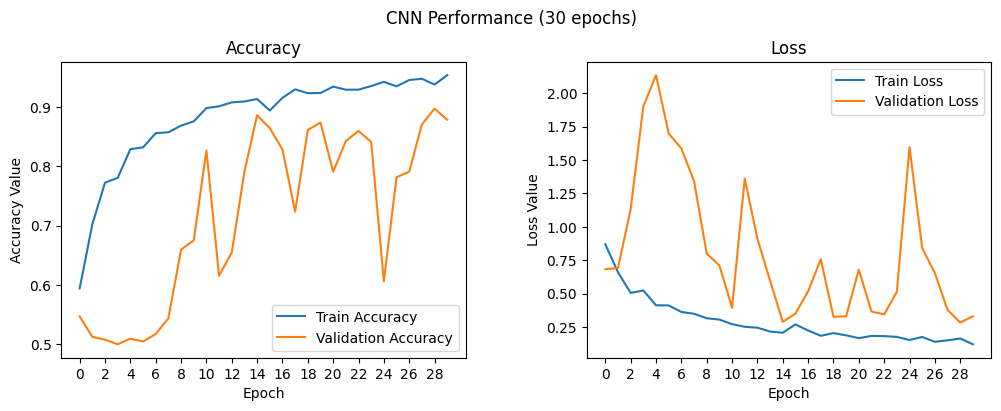

In [108]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN #5 Performance (30 epochs)', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(0, 30))
ax1.plot(epoch_list, history5.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history5.history['val_accuracy'], label='Validation Accuracy')

ax1.set_xticks(np.arange(0, 30, 2))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history5.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history5.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 30, 2))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

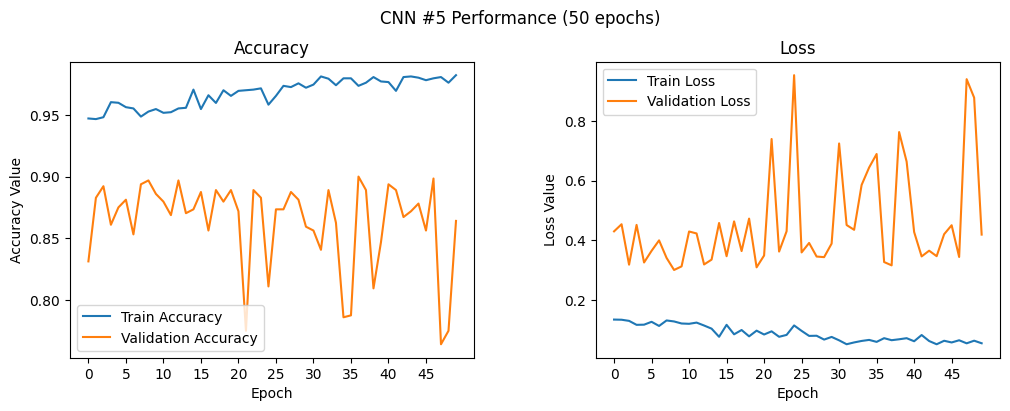

In [123]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN #5 Performance (50 epochs)', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(0, 50))
ax1.plot(epoch_list, history6.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history6.history['val_accuracy'], label='Validation Accuracy')

ax1.set_xticks(np.arange(0, 50, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history6.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history6.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 50, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

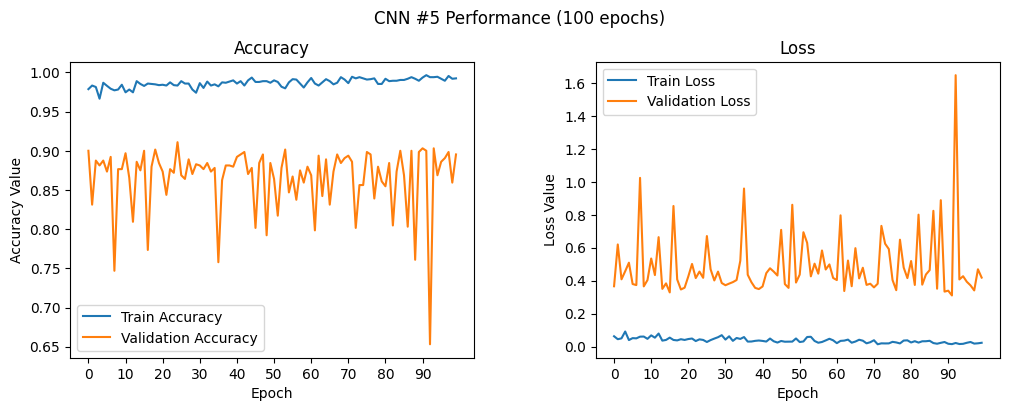

In [126]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN #5 Performance (100 epochs)', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(0, 100))
ax1.plot(epoch_list, history7.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history7.history['val_accuracy'], label='Validation Accuracy')

ax1.set_xticks(np.arange(0, 100, 10))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history7.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history7.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 100, 10))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## 3.4 Testing the best CNN and making predictions

### 3.4.1 Making predictions

In [198]:
path_test = '/Users/yuliabezginova/PycharmProjects/00_files-for_NLP/shift-cv-winter-2023/'

In [202]:
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_directory(
directory=path+'/test/',
batch_size=32,
seed=5,
shuffle=False,
class_mode=None,
target_size=(96,96))

Found 774 images belonging to 1 classes.


In [208]:
test_generator.filenames

['test/aamnsxdfcsnrdkyczxnm.jpg',
 'test/acgycwqzujjxrigweldc.jpg',
 'test/achfvibipchzipmhtjow.jpg',
 'test/adicqesamknapclvcesb.jpg',
 'test/aefilcxppgkwhnusvziq.jpg',
 'test/afbmymiwhhvozvwexzty.jpg',
 'test/agsxpjnxlikqtitjyivk.jpg',
 'test/ahhoaringspcwydusezm.jpg',
 'test/ahqjkaowvephhufdlvgu.jpg',
 'test/ajvtvvkutaphcgashzvg.jpg',
 'test/akpedwlmvfgipnhviufr.jpg',
 'test/ambstcwzvhqxqmocuryr.jpg',
 'test/amcyvzprallpofwrugll.jpg',
 'test/amrqjubcbdohtaqnvpps.jpg',
 'test/anfevagjcqdjqmwwlmll.jpg',
 'test/aokafwotfflenmfzyyuo.jpg',
 'test/aokmotpfevqikpmwfqwu.jpg',
 'test/aolwdjviypgegcstmhru.jpg',
 'test/aowheuufqxlfkepkfpvq.jpg',
 'test/aqjepqjnrymrwmlnvdaz.jpg',
 'test/asccexyuuyrtistxedwx.jpg',
 'test/atmycuvwoxgqwzarzdbu.jpg',
 'test/atoinaiktqfxknqlnukb.jpg',
 'test/avgbkpxmnbhcwsefrfkg.jpg',
 'test/avyntacsmhdnozlckspe.jpg',
 'test/axrwgapnnuhhugshgqut.jpg',
 'test/axwqnvsyiuqhfygkwmmo.jpg',
 'test/ayfgnuvqgptisrxcoqnq.jpg',
 'test/aympdffhfzpyffrvvqqv.jpg',
 'test/azhhybb

In [249]:
test_predict = model5.predict_generator(test_generator)
test_predict.shape

(774, 1)

In [262]:
type(test_predict)

numpy.ndarray

In [296]:
def create_blur(predicts, filenames):
    
    dict_result = {'filename' : [], 
            'blur' : []}
    
    for i in range(len(filenames)): # enumerate(filenames): # enumerate is a function whic returns iteration index
        splitted = filenames[i].split('/')
        
        dict_result['filename'].append(splitted[-1])
    
        if predicts[i][0] < 0.8:
            dict_result['blur'].append(0)
        else:
            dict_result['blur'].append(1)
            
    result = pd.DataFrame(dict_result)
    return result

In [297]:
result = create_blur(test_predict, test_generator.filenames)

In [298]:
result.to_csv('/Users/yuliabezginova/PycharmProjects/CV_02_BlurredImagesDetection/result.csv', index=None)

In [303]:
result = pd.read_csv('/Users/yuliabezginova/PycharmProjects/CV_02_BlurredImagesDetection/result.csv')
result.head(20)

filename  blur
0   aamnsxdfcsnrdkyczxnm.jpg     0
1   acgycwqzujjxrigweldc.jpg     0
2   achfvibipchzipmhtjow.jpg     1
3   adicqesamknapclvcesb.jpg     0
4   aefilcxppgkwhnusvziq.jpg     0
5   afbmymiwhhvozvwexzty.jpg     0
6   agsxpjnxlikqtitjyivk.jpg     0
7   ahhoaringspcwydusezm.jpg     0
8   ahqjkaowvephhufdlvgu.jpg     0
9   ajvtvvkutaphcgashzvg.jpg     0
10  akpedwlmvfgipnhviufr.jpg     0
11  ambstcwzvhqxqmocuryr.jpg     1
12  amcyvzprallpofwrugll.jpg     0
13  amrqjubcbdohtaqnvpps.jpg     0
14  anfevagjcqdjqmwwlmll.jpg     0
15  aokafwotfflenmfzyyuo.jpg     0
16  aokmotpfevqikpmwfqwu.jpg     0
17  aolwdjviypgegcstmhru.jpg     1
18  aowheuufqxlfkepkfpvq.jpg     0
19  aqjepqjnrymrwmlnvdaz.jpg     0

### 3.4.2 Testing how well CNN works

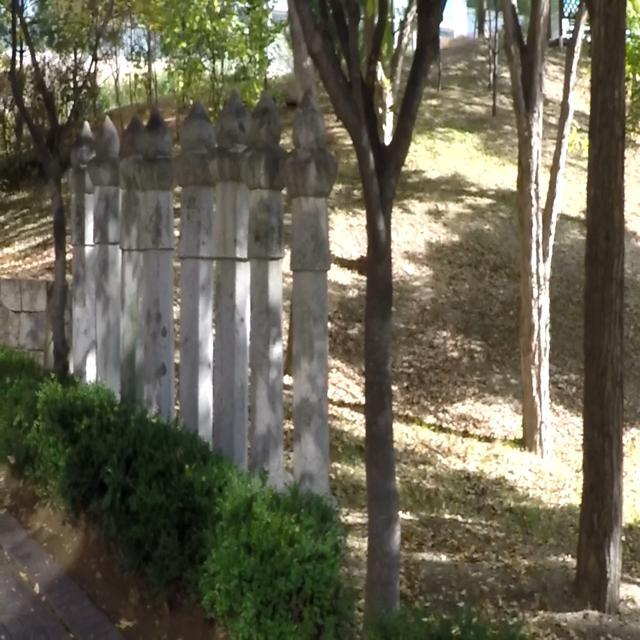

In [38]:
# manual testing - correct, 1=blurred
img_test = Image.open('/Users/yuliabezginova/PycharmProjects/00_files-for_NLP/shift-cv-winter-2023/test/test/aqjepqjnrymrwmlnvdaz.jpg')
img_test

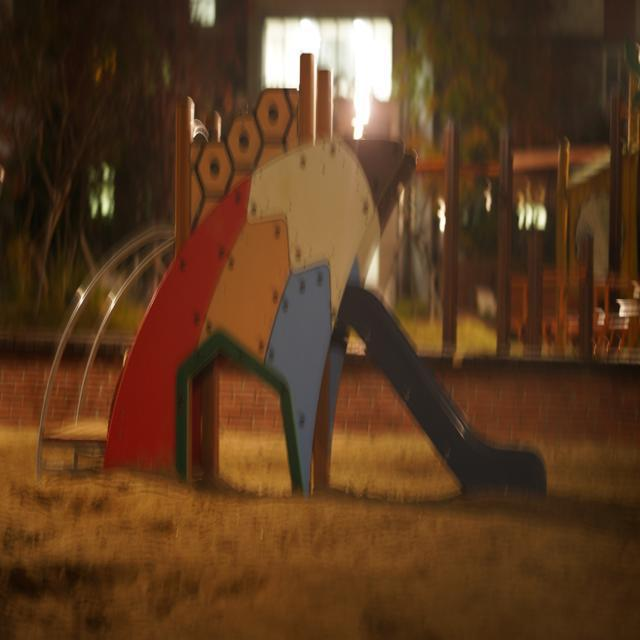

In [39]:
# manual testing - correct, 1=blurred
img_test = Image.open('/Users/yuliabezginova/PycharmProjects/00_files-for_NLP/shift-cv-winter-2023/test/test/achfvibipchzipmhtjow.jpg')
img_test

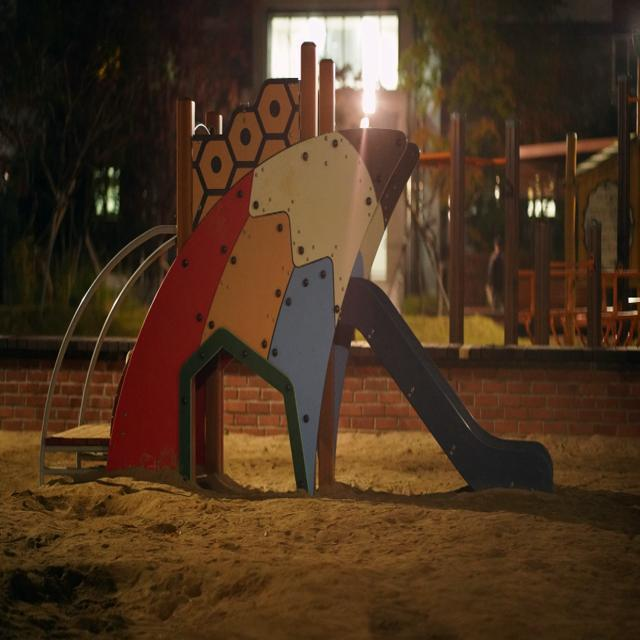

In [301]:
# manual testing - correct: 0, sharp
img_test = Image.open('/Users/yuliabezginova/PycharmProjects/00_files-for_NLP/shift-cv-winter-2023/test/test/aefilcxppgkwhnusvziq.jpg')
img_test

# 4 Final conclusions

## 4.1 Comparing predictions of two different approaches - Laplacian algorithm and CNN

### As for final model output, the predictions are written into .csv dataframes for two models - Laplacial algorithm and CNN. From the above Laplacian algorithm output, we can conclude that Laplacian model makes mistakes in the blurry images detection. Now we can check how many mistakes Laplacian makes comparing to CNN, and confirm whether CNN indeed is better for image recognition.

In [371]:
df_result = pd.merge(result_laplacian, result, on = 'filename')

In [372]:
df_result.head()

filename  blur_x  blur_y
0  fypnbvdjytoeycwfkbof.jpg       1       0
1  uvrujzuyrklrsokmgmnc.jpg       1       1
2  oxvalbmdruepdvalmovq.jpg       1       1
3  rdqmlrqscqxevtllbwpl.jpg       1       0
4  oqpwiybzirgxxxlbvrag.jpg       1       0

In [373]:
df_result.rename(columns = {'blur_x':'pred_laplacian',
                            'blur_y':'blur_cnn'}, inplace = True)

In [374]:
df_result.head(10)

filename  pred_laplacian  blur_cnn
0  fypnbvdjytoeycwfkbof.jpg               1         0
1  uvrujzuyrklrsokmgmnc.jpg               1         1
2  oxvalbmdruepdvalmovq.jpg               1         1
3  rdqmlrqscqxevtllbwpl.jpg               1         0
4  oqpwiybzirgxxxlbvrag.jpg               1         0
5  fzlcmpfpfqymcngmwgwg.jpg               1         1
6  turudimbdmpzwxilfnwj.jpg               0         0
7  ejgrodzlnaxwirnyjvfu.jpg               0         0
8  fbjnxsvpqgnvumdbupcg.jpg               1         1
9  srldvfcqyidfrxuzital.jpg               1         1

In [375]:
df_result['comparison'] = df_result['pred_laplacian'] == df_result['blur_cnn']
diff_pred = (df_result[df_result['comparison'] == False]['comparison'].count()) / len(df_result) * 100

In [376]:
print('How different Laplacian algorithm in predictions:', round(diff_pred, 2), '%')

How different Laplacian algorithm in predictions: 17.57 %


In [377]:
blur_laplacian = (df_result[df_result['pred_laplacian'] == 1]['pred_laplacian'].count())
print('Number of blurry images via Laplacian algorithm:', blur_laplacian)

Number of blurry images via Laplacian algorithm: 380


In [378]:
blur_cnn = (df_result[df_result['blur_cnn'] == 1]['blur_cnn'].count())
print('Number of blurry images via CNN:', blur_cnn)

Number of blurry images via CNN: 262


### ***Conclusion***: Laplacian algorithm differs from CNN predictions for 32.95 %: while Laplacian model detects 380 images as blurred, CNN identifies 262 images, which looks more true. This means that despite a predeveloped Fourier or Laplacian thresholds for detecting blurry images, neural network gives more reliable predictions.

## 4.2 Summary

### As a result of project, after tuning five different convolutional neural network algorithms, we have received two strong CNNs which are able to classify the images into blurred=1 / non-blurred=0:
- **Model 3** ('Adam' optimizer, learning_rate=0.0001)

```Epoch 30/30
62/62 - 22s - loss: 0.0562 - accuracy: 0.9842 - val_loss: 0.4524 - val_accuracy: 0.8531 - 22s/epoch - 362ms/step
CPU times: user 28min 20s, sys: 5min 32s, total: 33min 53s
Wall time: 11min 22s```

- **Model 5** ('Adamax' optimizer)


```Epoch 30/30
62/62 - 48s - loss: 0.1204 - accuracy: 0.9532 - val_loss: 0.3296 - val_accuracy: 0.8781 - 48s/epoch - 780ms/step
CPU times: user 1h 11min 56s, sys: 8min 52s, total: 1h 20min 49s
Wall time: 24min 52s```

### Model 3 shows a 98.42% accuracy on the train sample and 85.31% accuracy on the validation sample. While Model 5 shows 95.32% accuracy and 87.81% respectively. The loss function for validation sample is less for the Model 5, which means that the local minimun was better found for Model 5 and the loss function was minimized while training. In terms of execution, Model 3 is twice quicker than Model 5. 

### ```sigmoid``` vs. ```softmax```

The ```sigmoid``` activation function works better than the ```softmax``` activation function for certain types of tasks and data because of the way it maps input values to output values.

- ```sigmoid``` is a function that maps any input value to a value between 0 and 1, which makes it useful for binary classification tasks where the output must be a probability of the input belonging to one of two classes. For example, a sigmoid function can be used to predict the probability of an email being spam or not spam.

- On the other hand, the ```softmax``` function is used to map input values to a probability distribution over multiple classes. It is often used in multi-class classification problems, such as recognizing different types of fruits in an image.

**In the project, we are working on a binary classification task, it's likely that the ```sigmoid``` activation function would work better than the softmax function because it is specifically designed to handle this type of problem. The sigmoid function provides a probability of the input belonging to one of two classes, whereas the softmax function is designed to work with multiple classes.**

**Additionally, sigmoid function is computationally less expensive than softmax function, which could also be one of the reasons for sigmoid performing better in your project.**

### Keeping in mind the issue of overfitting, we recommend to use Model 5 for business purposes. Model 5 was tuned for 30, 50, and 100 epochs in a row; the loss function is minimized for every of the tuning round.

- Regularization ```Dropout(0.25)``` was added to each convolution layer;
- ```Batch Normalization``` was added to each layer as advised in the research literature (Liu, 2008; Hsu, 2008, Su et al., 2011);
- activation function is ```sigmoid```


### As a final solution for this project, the classified ```result.csv``` file was generated with predictions for unseen sample of 774 images.